# Representational similarity analysis 
This workshop covers the basics of representational similarity analysis (RSA) in R. We will use synthetic behavioral data and <i> real </i> neural data from the Sherlock movie-watching dataset, analyzed in this lovely <a href="https://www.nature.com/articles/nn.4450">paper</a> by Chen et al. Participants watched a full episode of the TV show Sherlock (approx. 45 minutes; 1976 TRs). The episode was divided into 50 scenes by the experimenters. The functional images were z-scored per voxel. The behavioural ratings and semantic similarity matrices were generated by infusing some structure in otherwise random numbers. The analyses here are only meant to provide general intuition. <br>
The full dataset is freely available for download <a href="https://dataspace.princeton.edu/jspui/handle/88435/dsp01nz8062179">here</a>. I have provided the extracted timecourses for two regions of interest for three participants in the tutorial materials. <br>
Aims: <br>
1. Generate and plot behavioral representational similarity matrices
2. Generate and plot neural representational similarity matrices
3. Extend the logic of RSA to across-participant measures, often used in naturalistic datasets

<br>
Typically, RSA is conducted by deriving average voxel-wise patterns associated with a particular condition (e.g., viewing houses vs. viewing faces), or by estimating trial-by-trial voxel-wise patterns. The general logic is as follows: if two stimuli evoke a similar response in a set of voxels, they share something in their representation as they are supported by overlapping populations.
<br> 
In recent years, naturalistic approaches such as movie-watching, in-scanner recall, and imagery have become increasingly popular and commonplace in fMRI. RSA is a flexible (and fun!) technique that allows us to investigate patterns at different levels of granularity. This is the focus of the present tutorial. For traditional approaches to RSA, important caveats to consider, and key aspects to think about when designing your study, please refer to the excellent papers by <a href="https://www.sciencedirect.com/science/article/pii/S1364661313001277">Kriegeskorte & Kievit</a>, <a href="https://www.sciencedirect.com/science/article/pii/B9780128120286000276">Dimsdale-Zucker & Ranganath</a>, and <a href="https://academic.oup.com/scan/article/14/11/1243/5693905">Popal et al</a>. If you're interested in hippocampal representations, a <a href="https://www.sciencedirect.com/science/article/abs/pii/S0149763420304838">this review</a> we wrote with Jess Robin might be of interest. 

In [1]:
# load libraries
(library(plyr))
(library(dplyr))
(library(ggplot2))
(library(superheat))
(library(gplots))
(library(viridis))
(library(psych))
# if the superheat CRAN install isn't working, uncomment below:
##install.packages("devtools")
##devtools::install_github("rlbarter/superheat")

# initialize figure settings - only use if running a jupyter notebook!
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 100)


Warning message:
"package 'plyr' was built under R version 3.6.3"


[1] "plyr"      "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] "dplyr"     "plyr"      "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"

Warning message:
"package 'ggplot2' was built under R version 3.6.3"


[1] "ggplot2"   "dplyr"     "plyr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

Warning message:
"package 'superheat' was built under R version 3.6.3"


[1] "superheat" "ggplot2"   "dplyr"     "plyr"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

Warning message:
"package 'gplots' was built under R version 3.6.3"

Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess




[1] "gplots"    "superheat" "ggplot2"   "dplyr"     "plyr"      "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

Warning message:
"package 'viridis' was built under R version 3.6.3"
Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 3.6.3"


[1] "viridis"     "viridisLite" "gplots"      "superheat"   "ggplot2"    
 [6] "dplyr"       "plyr"        "stats"       "graphics"    "grDevices"  
[11] "utils"       "datasets"    "methods"     "base"


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha




[1] "psych"       "viridis"     "viridisLite" "gplots"      "superheat"  
 [6] "ggplot2"     "dplyr"       "plyr"        "stats"       "graphics"   
[11] "grDevices"   "utils"       "datasets"    "methods"     "base"

In [2]:
# read ratings for each scene in movie for one subject
behav_data <- read.table("sherlock_events_s1.csv", header=T, sep=",")
behav_data$event_label <- as.factor(behav_data$event_label)


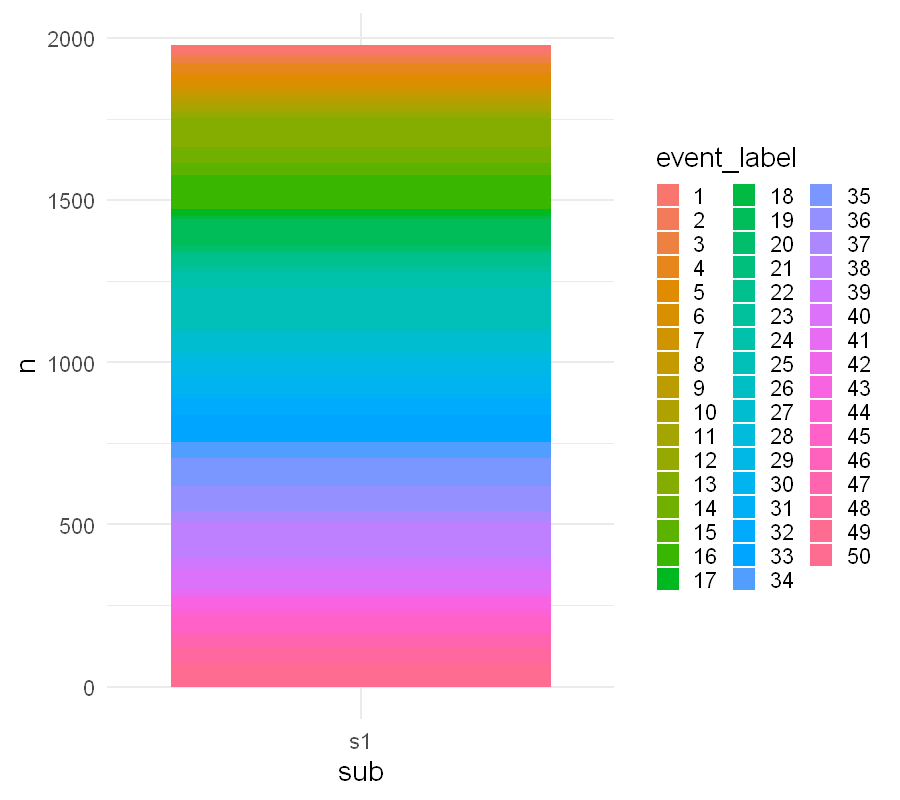

In [3]:
# plot by event - this is really useful when you have different values across participants, e.g. in recall data

ggplot(behav_data %>% count(sub,event_label) %>%    
         mutate(pct=n/sum(n)),  
       aes(sub,n, fill=event_label)) +
    geom_bar(stat="identity") + 
    theme_minimal(base_size=20)


## 1) Behavioral representational similarity matrices
There are two main approaches/data structures that we tend to encounter. <br>
1. We may already have a behavioral similarity matrix derived independently (e.g. semantic similarity), OR
2. We may have event-by-event ratings/scores/measures, and we want to quantify the dissimilarity between them.
Let's look at each in turn.


### 1. Semantic similarity matrix example
Matrices such as this one are generated by LSA/word2vec/etc. The one here is a synthetic matrix of similarity values, but this is how we would approach working with an existing matrix of any kind.

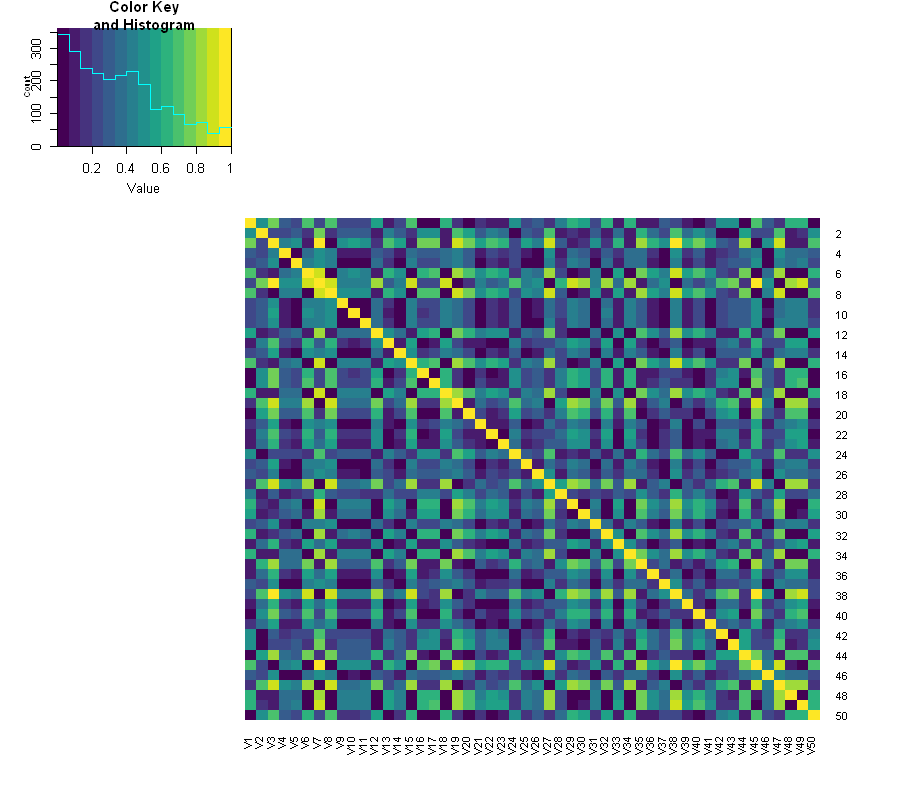

In [4]:
semantic_sim <- as.matrix(read.table("semantic_sim_synthetic.csv", sep=",", header=F))

# visualize semantic similarity
heatmap.2(semantic_sim, dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis )

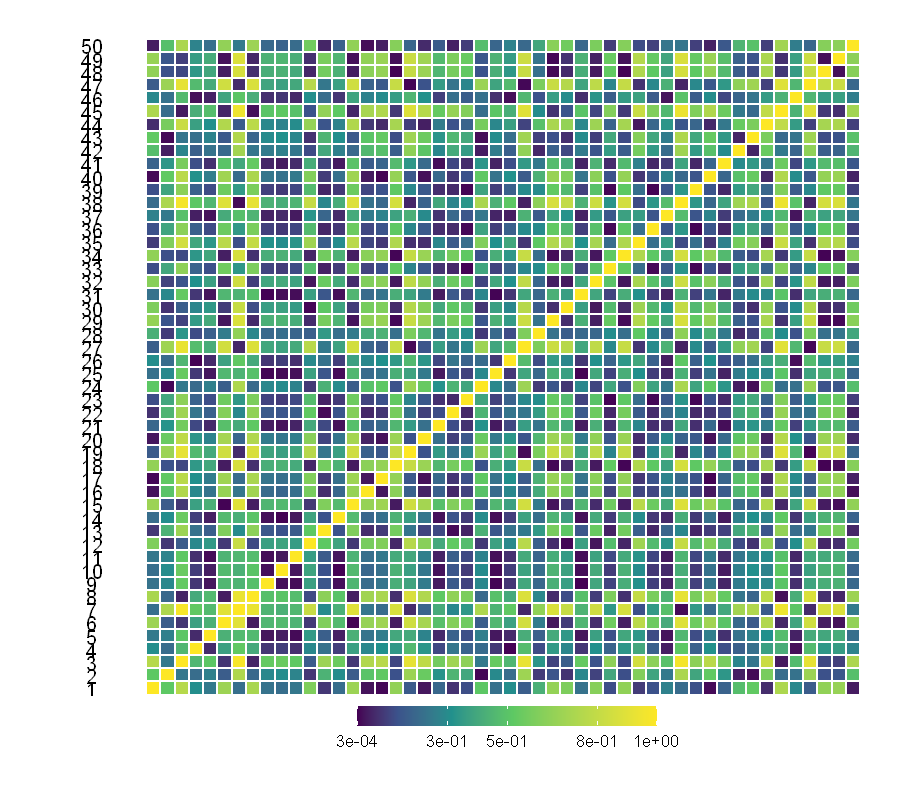

In [5]:
# for PRETTY and highly customizable plots, try the 'superheat' package
# it takes much longer to run, but it's very flexible and allows you to plot all sorts of matrices, not just symmetric ones
superheat(semantic_sim,
          bottom.label = "none",
          left.label.col = "white",
          left.label.size = 0.15,
          grid.vline.col = "white",
          grid.hline.col = "white",
          grid.vline.size = 1,
          grid.hline.size = 1)

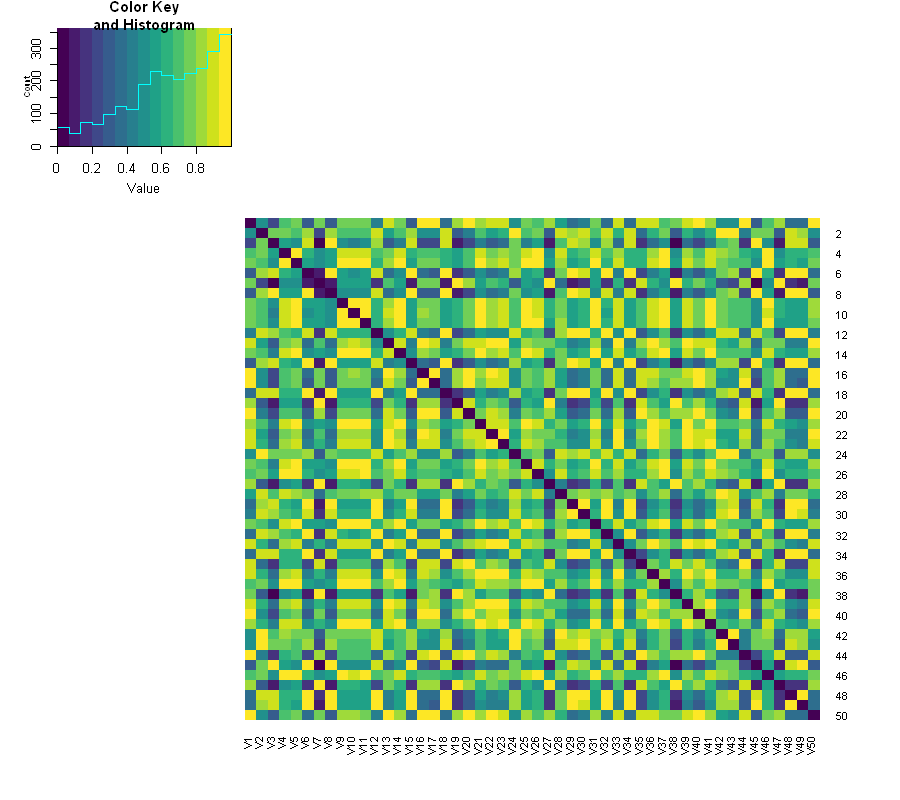

In [6]:
# we can also look at representational DISsimilarity 
# which is the inverse of similarity, as we might expect
# we might want to do this to make our predictions consistent in either direction (higher is always better/worse)
semantic_dist <- 1 - semantic_sim

heatmap.2(semantic_dist, dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis )

In [ ]:
# superheat version
superheat(semantic_dist,
          bottom.label = "none",
          left.label.col = "white",
          left.label.size = 0.15)

### 2. Event-by-event ratings example
Perhaps more commonly, we'll have ratings/measures relating to each event that participants watched. We might have these ratings for each participant (like here), or they could be the same for all events watched by all participants (e.g., luminance in each scene). Here, let's say our synthetic measure represents the rating of how interesting each TR is, as rated by the participant. In the real world, we're unlikely to have behavioral data with such high resolution, but we might have eye movements, RTs, heart rate, etc. <br>
At any rate, we want to create a matrix similar to the one above, representing the similarity in ratings across all 50 events in the movie. However, we obviously can't rely on correlations, as we only have a single value per scene. We will generate a distance matrix instead (roughly equivalent to 1-similarity; lower values mean lower distance and therefore greater similarity).


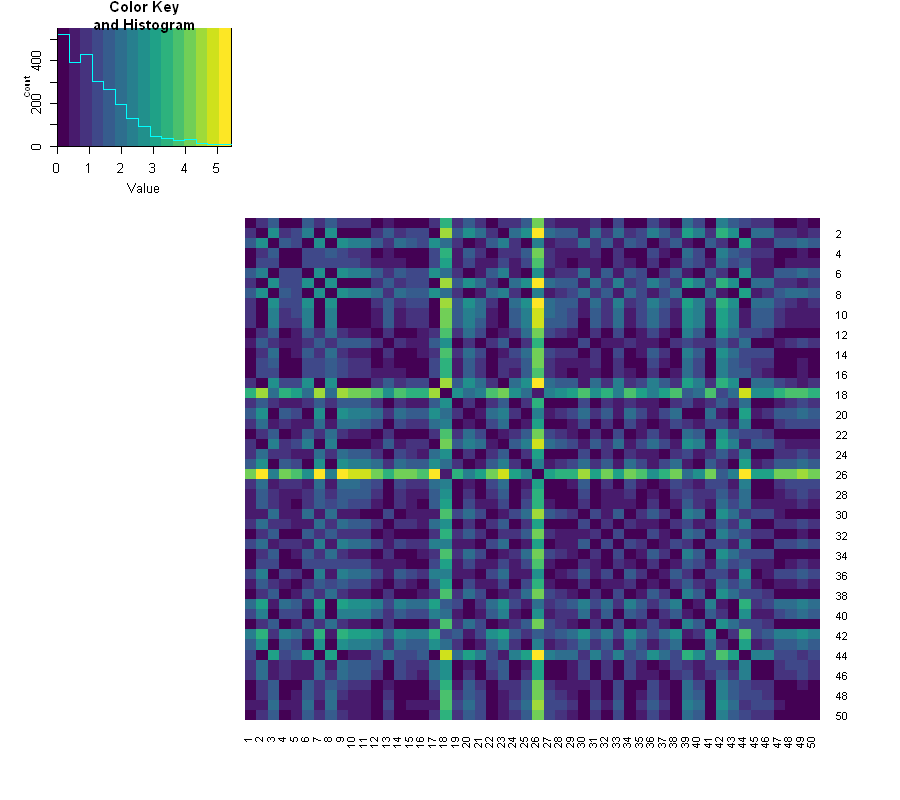

In [7]:
# now, let's create a distance matrix for our event ratings

# calculate average rating per event
behav_per_event <- behav_data %>%
  group_by(event_label) %>%
  summarise(mean_rating = mean(rating))

# generate distance matrix
behav_dist <- as.matrix(dist(behav_per_event$mean_rating))
# the 'dist' function in R has a few parameters you can change, including the particular distance measure you want to use

# plot distance matrix as above
heatmap.2(behav_dist, dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis )

Now, for the representational <i> similarity </i> part. All without any neural data! The logic is exactly the same though - let's see whether the pattern in our ratings of interest we just plotted above is related to the pattern in semantic similarity ratings. Perhaps events more similar to one another in semantic space are also more similar in their interestingness.

In [9]:
# convert both matrices to vectors in the same way
# it is VERY important to only include the lower/upper triangle and NOT to include the diagonal
# in R, the upper.tri function accomplishes this (or lower.tri - with symmetric matrices, it's irrelevant)

# this organizes the extracted values by column number
# this is the default setting, but if you want to order it by row, simply swap 'col' for 'row'
behav_vec <- behav_dist[upper.tri(behav_dist)][order(col(behav_dist)[upper.tri(col(behav_dist))])]

# the same logic with the semantic similarity matrix
semantic_vec <- semantic_dist[upper.tri(semantic_dist)][order(col(semantic_dist)[upper.tri(col(semantic_dist))])]


In [ ]:
# uncomment below to double check
#length(behav_vec)
#length(semantic_vec)

In [10]:
# now, we can correlate them
cor.test(behav_vec, semantic_vec)


	Pearson's product-moment correlation

data:  behav_vec and semantic_vec
t = 0.85722, df = 1223, p-value = 0.3915
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03154774  0.08040319
sample estimates:
       cor 
0.02450455 


We just ran a representational similarity analysis! It seems like the matrices of interest and semantic similarity were unrelated in this particular participant. What about their neural patterns? 
<br>
(Caveat to consider: this was a Pearson product-moment correlation; depending on your data, different correlation approaches may be more appropriate! For a primer, see <a href="https://content.sciendo.com/view/journals/quageo/30/2/article-p87.xml">this paper</a>.)


## 2) Neural representational similarity matrices

First, we'll load voxel-wise timecourses for a few different ROIs. These are already extracted. This is very easy to do with the FSL 'fslmeants' function, for example. Happy to help if you want to run this on your own data and encounter any issues! <br> Let's have a look at the medial prefrontal cortex (mPFC; in red), and early visual cortex (EVC; in yellow).
<img src="ROIs_masks.png" style="width: 200px;"/>

In [11]:
# load neural data (voxel-wise extracted timecourses) for one participant
mpfc_data <- read.table("s1_mPFC_meants.txt", sep="", header=F, skip=4)
evc_data <- read.table("s1_EVC_meants.txt", sep="", header=F, skip=4)


In [ ]:
# uncomment below to see the dimensions of the data
#dim(mpfc_data)
#dim(evc_data)

#### !! Do NOT run the cell below, just look at the plot!!
We <i> could </i> just correlate each TR to every other TR in the entire movie. This can reveal any structure that might be present in the data. It is, however, computationally intensive (even just for one ROI in one participant). Which is not to say that looking at data TR-by-TR is not informative - it can be used in an interesting and thoughtful way <a href="https://www.sciencedirect.com/science/article/pii/S0896627317305937">like in this paper</a>.

<img src="trxtr_matrix.png" style="width: 500px;"/>

In [ ]:
####### DON'T RUN THIS CELL - JUST HAVE A LOOK AT THE PLOT ABOVE! #####
# it takes ~ 10 minutes to run 
# we CAN just correlate the pattern at each TR with every other one
# but this isn't the ideal approach (with 520 voxels and almost 2000 TRs!)

# transpose so now TRs are columns
mpfc_t <- t(mpfc_data)
mpfc_mat <- as.matrix(mpfc_t)

# the cor function correlates each column with every other one
mpfc_cor <- cor(mpfc_mat)

# this is our 1976 x 1976 matrix - not actually very helpful!
heatmap.2(mpfc_cor,dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis)

A better approach might be to average across TRs <i> within </i> each event. This gives us an estimate of the general pattern present across voxels in each ROI, within each event. We can then generate a correlation matrix from these event representations.

In [12]:
# aggregate per event within each ROI

mpfc_labeled <- cbind(behav_data$event_label, mpfc_data)
mpfc_per_event <- aggregate(mpfc_labeled[, 2:ncol(mpfc_labeled)], list(mpfc_labeled[,1]), mean)

evc_labeled <- cbind(behav_data$event_label, evc_data)
evc_per_event <- aggregate(evc_labeled[, 2:ncol(evc_labeled)], list(evc_labeled[,1]), mean)


In [ ]:
# uncomment below to look at dimensions of the data
#dim(mpfc_per_event)
#dim(evc_per_event)
#evc_per_event


In [13]:
# remove first column with event label
mpfc_per_event[1] <- NULL
evc_per_event[1] <- NULL

In [14]:
# now, we can correlate the averaged patterns, per event, to each other

# first, we have to transpose (so each column is an event)
mpfc_t <- t(mpfc_per_event)
evc_t <- t(evc_per_event)
#dim(mpfc_t)

# now, calculate the full correlation matrix
mpfc_cor <- cor(as.matrix(mpfc_t))
evc_cor <- cor(as.matrix(evc_t))

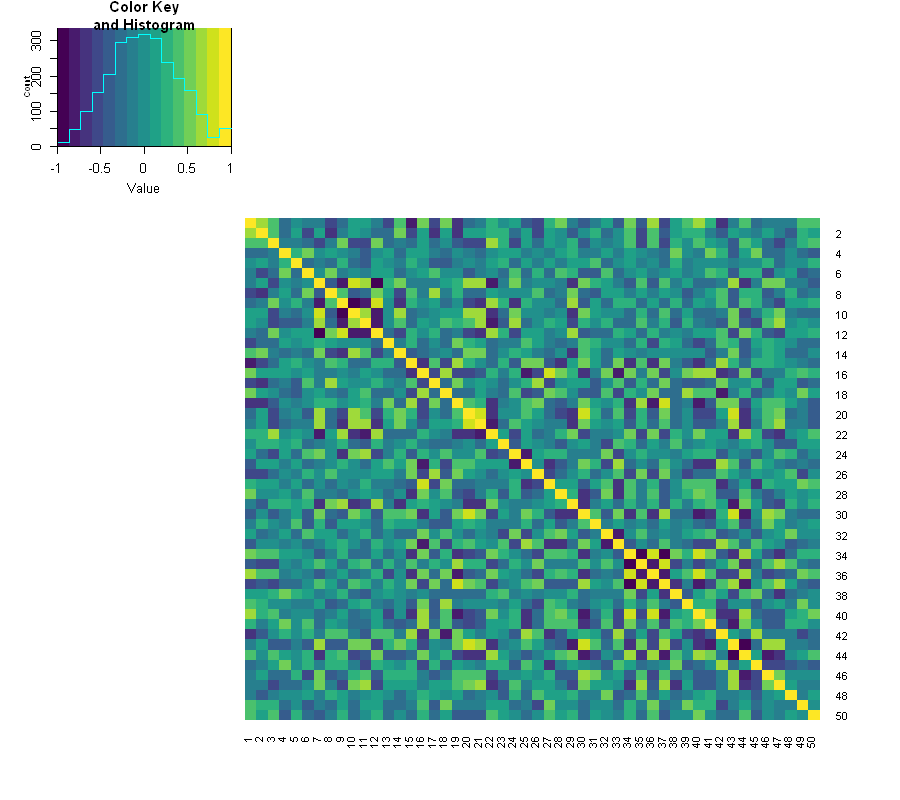

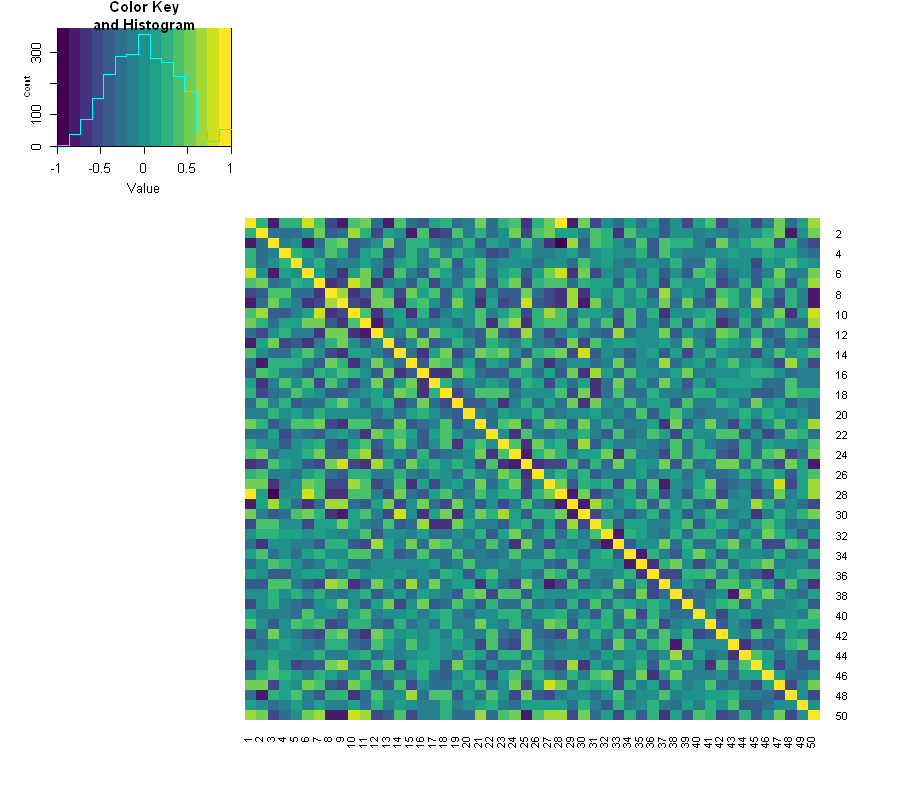

In [15]:
# we can now plot the resulting matrices
heatmap.2(mpfc_cor,dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis)
heatmap.2(evc_cor,dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis)


We now have our correlation matrices of the representational structure across the 50 events (semantic, behavioral ratings, neural). We can now try to explore whether there is any representational structure corresponding to events apparent in the neural matrix. Next, we can relate the matrices to one another.

### Uncovering event structure in neural data
First, let's see whether the known events in the movie evoke above-zero similarity in neural patterns in either mPFC or EVC. The logic here is: if the average similarity across all events is zero, this means that any two events are equally likely to be dissimilar or similar to one another. In our particular example, this analysis doesn't make the most sense as we would expect that variability across events will wash out similarity. <br>
However, in the example of looking at encoding-retrieval similarity, you <i> would </i> expect above-zero off-diagonal similarity, if a region represents the same concept consistently.



In [16]:
# grab the upper triangle 
mpfc_vec <- mpfc_cor[upper.tri(mpfc_cor)][order(col(mpfc_cor)[upper.tri(col(mpfc_cor))])]
evc_vec <- evc_cor[upper.tri(evc_cor)][order(col(mpfc_cor)[upper.tri(col(mpfc_cor))])]

# before comparing correlations, we should convert them to Fisher z coefficients
mpfc_z <- fisherz(mpfc_vec)
evc_z <- fisherz(evc_vec)

mpfc_mean <- mean(mpfc_z)
evc_mean <- mean(evc_z)

mpfc_mean; evc_mean


[1] -0.02400957

[1] -0.02308546

We have now computed the mean similarity value per participant, per ROI. In a full analysis pipeline, we would of course write a loop (or in R, an <i> lapply</i>) to get the corresponding values for each participant. These values can then be compared against zero using a one-sample t-test. A value significantly above zero would suggest that all representations share something in common. A value significantly below zero would suggest that, on average, representations are differentiable from one another. No difference from zero would suggest that any two events are equally likely to be similar or dissimilar. <br>
A note on the above: while this analysis doesn't really make a lot of sense in our current dataset, the range of values is consistent with the literature. It's rare to get (dis-)similarity values > 0.2 or < -0.2.

### Relating neural representations to behavioral representations
Now, for the more interesting part: let's see whether the behavioural representations computed above are meaningfully related to the neural data. To do this, we simply correlate the two vectors that we have already generated.


	Pearson's product-moment correlation

data:  behav_vec and mpfc_z
t = 0.72603, df = 1223, p-value = 0.468
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03529390  0.07667597
sample estimates:
       cor 
0.02075612 



	Pearson's product-moment correlation

data:  behav_vec and evc_z
t = -0.5837, df = 1223, p-value = 0.5595
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.07262945  0.03935743
sample estimates:
        cor 
-0.01668835 


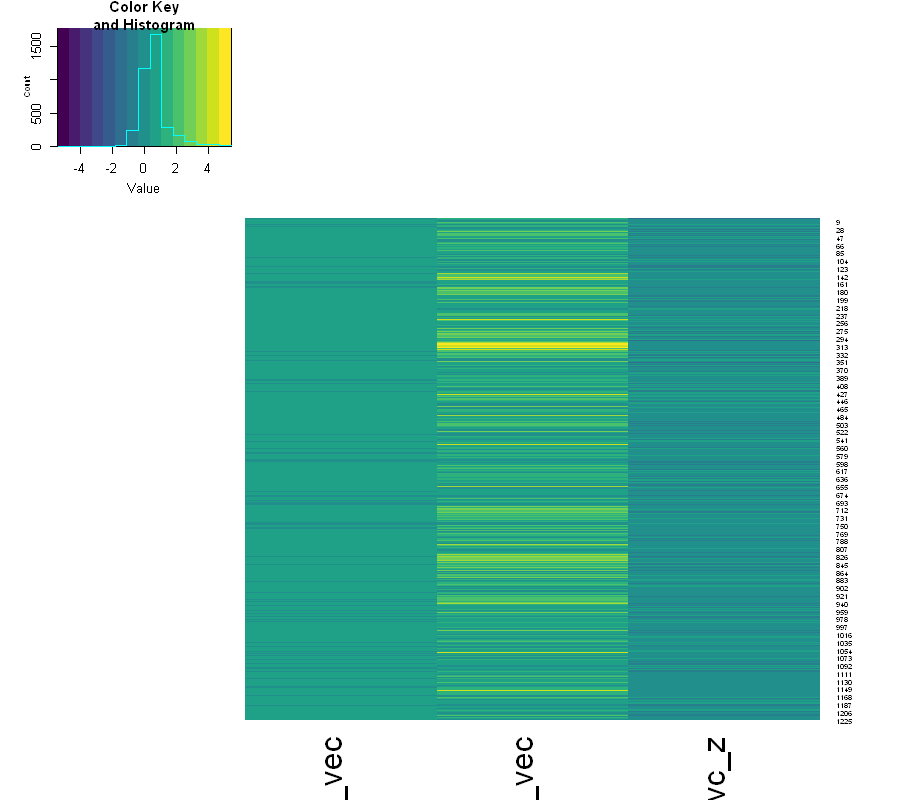

In [17]:
# this takes ~ 10 seconds to run
mpfc_behav <- cbind(semantic_vec, behav_vec, mpfc_z)
evc_behav <- cbind(semantic_vec, behav_vec, evc_z)
heatmap.2(evc_behav,dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none', col=viridis::viridis)

cor.test(behav_vec, mpfc_z)
cor.test(behav_vec, evc_z)

It looks like the neural patterns don't relate to behavior or semantic similarity in eiher of our chosen ROIs! (To be fair, that's a good thing, since both matrices were artifically generated). Now, let's recalibrate and think about representation from a broader perspective. <br>
Since all participants watched the same movie, we could say that a shared representation might be reflected in co-fluctuation of neural timecourses. Participants who are more in sync with every other participant might perceive events in a more similar way to every other participant, relative to those whose fluctuations vary in a different way.

## 3) Across-participant representational similarity
In the final part of the tutorial, let's explore how neural representations vary <i> across participants</i>. To do this, we can look at inter-subject correlation (ISC). Since the approach was <a href="https://science.sciencemag.org/content/303/5664/1634.abstract">first published</a>, many researchers have used it in really interesting <a href="https://www.nature.com/articles/nn.4450">ways</a>. Instead of looking at voxel-wise patterns as before, however, we'll be looking at region-specific timecourses.

In [18]:
# first, load the neural data, now for all three participants

filelist_mpfc <- list.files(pattern="*mPFC_meants.txt", full.names = F)
datalist_mpfc <- lapply(filelist_mpfc, function(x)read.table(x, header= F, sep = "", skip = 4))

filelist_evc <- list.files(pattern="*EVC_meants.txt", full.names = F)
datalist_evc <- lapply(filelist_evc, function(x)read.table(x, header= F, sep = "", skip = 4))

In [19]:
# data structure
filelist_mpfc
filelist_evc

subnames <- gsub("*_mPFC_meants.txt", "", filelist_mpfc)

names(datalist_mpfc) <- subnames
names(datalist_evc) <- subnames

summary(datalist_mpfc)
summary(datalist_evc)

[1] "s1_mPFC_meants.txt" "s2_mPFC_meants.txt" "s3_mPFC_meants.txt"

[1] "s1_EVC_meants.txt" "s2_EVC_meants.txt" "s3_EVC_meants.txt"

   Length Class      Mode
s1 520    data.frame list
s2 520    data.frame list
s3 520    data.frame list

   Length Class      Mode
s1 292    data.frame list
s2 292    data.frame list
s3 292    data.frame list

In [20]:
# calculate the average across all columns (i.e., ROI average timecourse)
mpfc_mean <- lapply(datalist_mpfc, function(x)rowMeans(x))
evc_mean <- lapply(datalist_evc, function(x)rowMeans(x))

# what we want to do now is loop over elements in the list
# this is a lot more intuitive to implement in Matlab & python
# but not impossible in R!

output_mpfc <- NULL; # initialize empty data frame
for(i in 1:length(mpfc_mean)){
    temp_vec <- as.data.frame(mpfc_mean[i]) # grab current participant's data frame
    held_out <- mpfc_mean[c(-i)] # temporarily remove the same data frame from the full list
    group_df <-  do.call(cbind, held_out) # combine all remaining participants in list
    group_mean <- as.data.frame(rowMeans(group_df)) # calculate average across all other participants
    temp_cor <- cor(group_mean, temp_vec) # correlate held out participant with other participants' average
    output_mpfc <- rbind(output_mpfc, temp_cor) # add to result data frame
    }

output_evc <- NULL;
for(i in 1:length(evc_mean)){
    temp_vec <- as.data.frame(evc_mean[i])
    held_out <- evc_mean[c(-i)]
    group_df <- do.call(cbind, held_out)
    group_mean <- as.data.frame(rowMeans(group_df))
    temp_cor <- cor(group_mean, temp_vec)
    output_evc <- rbind(output_evc, temp_cor)
    }

output_evc
output_mpfc

,s1
rowMeans(group_df),0.4303679
rowMeans(group_df),0.5573816
rowMeans(group_df),0.5257774


,s1
rowMeans(group_df),0.1689521
rowMeans(group_df),0.1933629
rowMeans(group_df),0.2364910


As expected, the synchronization across participants is a lot higher in early visual cortex than in mPFC! But even in mPFC, the correlations are not non-existent. Let's try plotting these data.

In [21]:
# plotting

# add columns to each dataframe with subject ID & index (this will help with plotting)
mpfc_mean <- lapply(mpfc_mean, function(x)mutate(as.data.frame(x), idx=row_number()))
mpfc_mean <- mapply(cbind, mpfc_mean, "sub"=subnames,  SIMPLIFY=F)

evc_mean <- lapply(evc_mean, function(x)mutate(as.data.frame(x), idx=row_number()))
evc_mean <- mapply(cbind, evc_mean, "sub"=subnames,  SIMPLIFY=F)

# bind all together - ggplot requires long data format
mpfc_df <- do.call(rbind, mpfc_mean)
evc_df <- do.call(rbind, evc_mean)


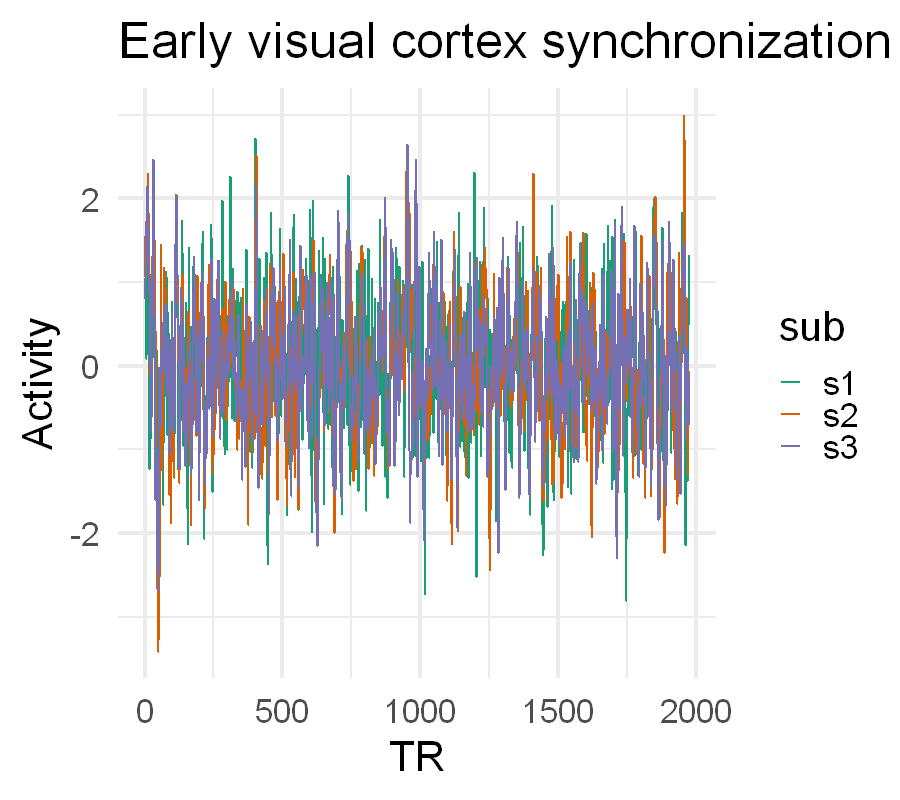

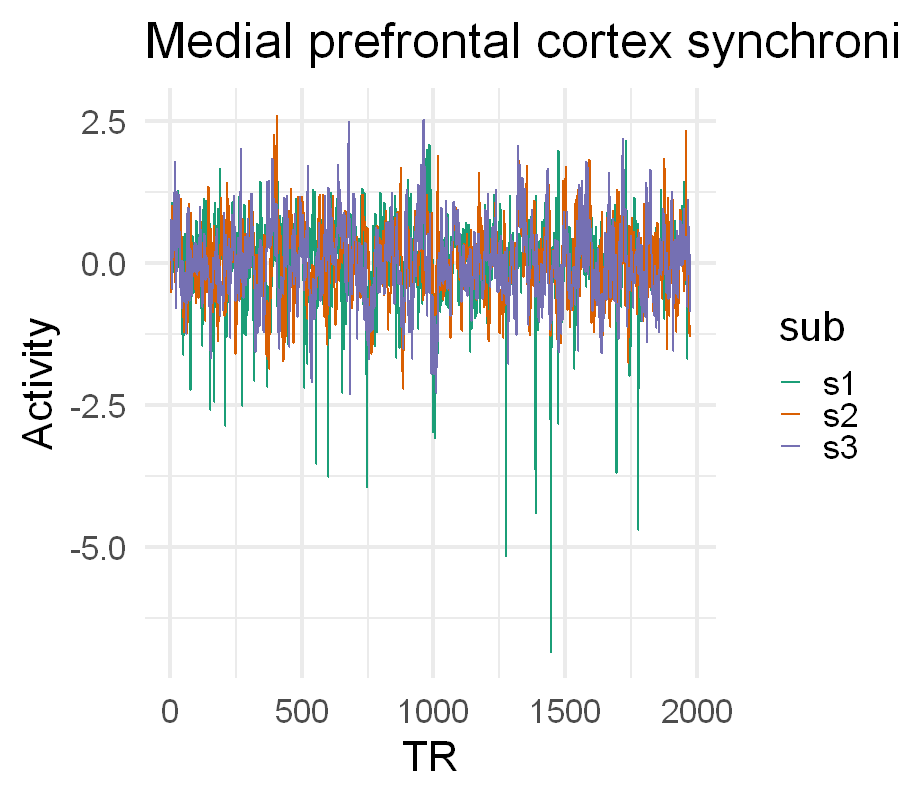

In [22]:
ggplot(evc_df, aes(x=idx, y=x, group=sub)) +
    geom_line(aes(color=sub),size=1) + 
    theme_minimal(base_size=30) +
    xlab("TR") + ylab("Activity") +
    ggtitle("Early visual cortex synchronization") + 
    scale_color_brewer(palette="Dark2") #+xlim(0, 200)

ggplot(mpfc_df, aes(x=idx, y=x, group=sub)) +
    geom_line(aes(color=sub),size=1) + 
    theme_minimal(base_size=30) +
    xlab("TR") + ylab("Activity") +
    ggtitle("Medial prefrontal cortex synchronization") + 
    scale_color_brewer(palette="Dark2") #+xlim(0, 200)

There are many more approaches we could try out - including across-participant representational similarity. But that requires extremely careful alignment across participants and consideration of the statistical approach (for those interested, look into <a href="https://www.sciencedirect.com/science/article/pii/S0896627311007811">hyperalignment</a>).

